In [1]:
import setigen_patch as stg # some **kwargs, slightly modified plots
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u

/home/obs/.conda/envs/seticore/lib/python3.12/site-packages/blimpy/__init__.py:21: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
%matplotlib inline

In [3]:
WINDOW_SIZE = 2**10
OUTPUT_FOLDER = "../../deliverables/injected/"

First I'll define MeerKAT band 5b parameters

In [4]:
lo, hi = 15.365*u.GHz, 15.38*u.GHz
center_freq = (lo+hi)/2
bandwidth = (hi-lo)
num_samples = 2**24
obs_time = 300 * u.s
n_ints = 16
df = bandwidth / num_samples
dt = obs_time / n_ints

dt, df.to(u.Hz)

(<Quantity 18.75 s>, <Quantity 0.89406967 Hz>)

In [5]:
frame = stg.Frame(
    fchans=num_samples,
    tchans=n_ints,
    df=df,
    dt=dt,
    fch1=hi,
)

In [6]:
T_rx = 10.6 * u.K + 0.633 *(u.K/u.GHz) * (center_freq - 8.41 * u.GHz)
T_sky = 5 * u.K
T_sys = T_rx + T_sky

## Add Noise
### $T_\text{rx}$
for this we have the inequality given in the technical specification:
$$ T_\text{rx} < 10.6 + 0.633\,(\nu - 8.41) $$
at frequency $\nu$. We will treat this as an equality in order to make a worst-scenario estimate

In [7]:
T_rx = lambda nu: 10.6*u.K + 0.633 * (nu - 8.41*u.GHz) * (u.K/u.GHz)

### $T_\text{sky}$

Which is $T_\text{atm} + T_\text{gal} + T_\text{cmb}$ namely the contributions are from respectively atmospheric emission, galactic synchrotron background and cosmic microwave background.

In [8]:
T_sky = lambda nu: 12*u.K # by chatgpt; TODO: ask how to calculate this

In [9]:
T_sys = lambda nu: T_rx(nu) + T_sky(nu)

### Power and error

In [10]:
k_B = 1.38e-23 * (u.J/u.K)
R = 50 * u.Ohm
P = k_B * T_sys(center_freq) * frame.df * u.Hz
P = P.to(u.yW)

N = (frame.df*u.Hz * frame.dt*u.s).to(u.dimensionless_unscaled)

sigma = P/np.sqrt(N) 
sigma = sigma.to(u.yW)

In [11]:
f"Power: {P :.4g} ± {sigma :.4g} over {N :.4g} samples"

'Power: 333.2 yW ± 81.39 yW over 16.76 samples'

In [12]:
noise = frame.add_noise(k=(N/2).value, theta=(2*P/N).value, noise_type='gamma')

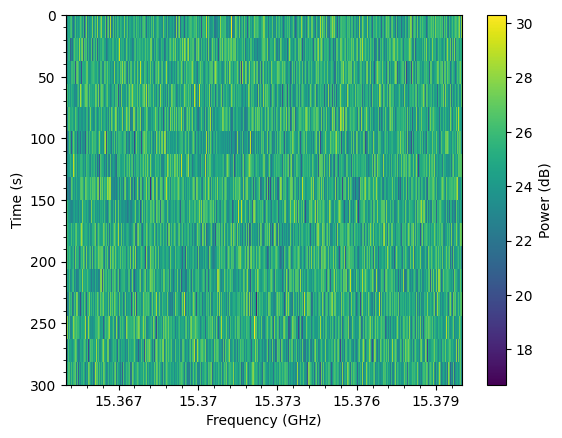

In [13]:
frame.plot('f', minor_ticks=True, db=True, funits="GHz", fdownsample=2**10)

In [14]:
def add_signal(frame, mean_freq, dr, snr, width):
    f_start = mean_freq - dr*frame.data.shape[0]*frame.dt*u.s/2
    
    return frame.add_signal(
        stg.constant_path(f_start=f_start,
                          drift_rate=dr),
        stg.constant_t_profile(level=frame.get_intensity(snr=snr)),
        stg.gaussian_f_profile(width=width),
        stg.constant_bp_profile(level=1)
    )

In [15]:
midf = 15.37*u.GHz ; dr  = 1.5 * (u.Hz/u.s);
width=1*u.Hz       ; snr = 100000

In [16]:
signal = add_signal(frame, midf, dr, snr, width)

In [17]:
frame.get_index(frequency=midf)

np.int64(5592404)

In [18]:
frame_s = frame.get_slice(
    (f := frame.get_index(frequency=midf)) - WINDOW_SIZE//2,
    f + WINDOW_SIZE//2
)

In [19]:
frame_s.data.shape

(16, 1024)

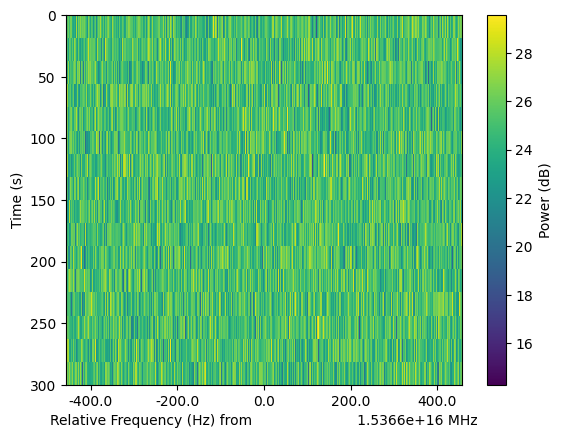

In [31]:
frame_s.plot()

In [21]:
frame.save_h5(OUTPUT_FOLDER + "meerKAT_high.h5")

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for ../../deliverables/injected/meerKAT_high.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 3.46sec


In [26]:
# ~SETICORE~ turboSETI RETURNED A HIT AT INDEX 349652, drift rate 1.53
i_hit = 699393

In [27]:
frame_s = frame.get_slice(
    i_hit - WINDOW_SIZE//2,
    i_hit + WINDOW_SIZE//2
)

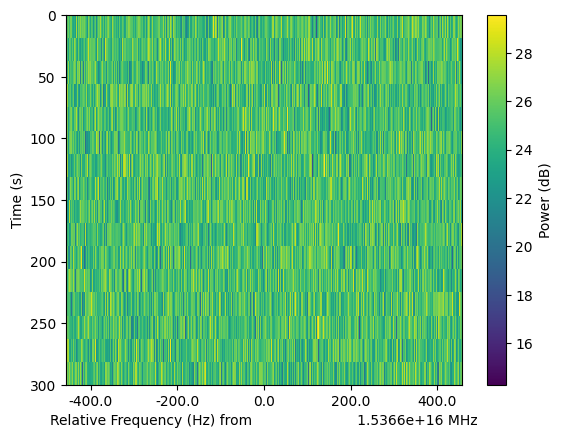

In [29]:
frame_s.plot()